In [28]:
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

%run preprocessing.ipynb

In [29]:
import warnings

warnings.filterwarnings("ignore")

In [30]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_preprocessed = preprocessing(train_data) # type: ignore
test_preprocessed = preprocessing(test_data) # type: ignore

print(train_preprocessed.info())

# Convert target variable to numeric if needed
train_preprocessed['Transported'] = train_preprocessed['Transported'].map({True: 1, False: 0}).astype(int)

# Split preprocessed training data into features and target
X = train_preprocessed.drop(columns=['PassengerId', 'Transported'])
y = train_preprocessed['Transported']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Prepare test data for prediction
X_test = test_preprocessed.drop(columns=['PassengerId'])
test_ids = test_preprocessed['PassengerId']



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   scaling__Age                                8693 non-null   float64
 1   scaling__RoomService                        8693 non-null   float64
 2   scaling__FoodCourt                          8693 non-null   float64
 3   scaling__ShoppingMall                       8693 non-null   float64
 4   scaling__Spa                                8693 non-null   float64
 5   scaling__VRDeck                             8693 non-null   float64
 6   scaling__Num                                8693 non-null   float64
 7   onehot_encoding__HomePlanet_Europa          8693 non-null   float64
 8   onehot_encoding__HomePlanet_Mars            8693 non-null   float64
 9   onehot_encoding__Destination_PSO J318.5-22  8693 non-null   float64
 10  onehot_encod

In [31]:
class SpaceshipDataset(Dataset):
    def __init__(self, features, labels=None):
        # Convert string columns to float
        features = features.astype(float) 
        self.features = torch.tensor(features.values, dtype=torch.float32)
        if labels is not None:
            self.labels = torch.tensor(labels.values, dtype=torch.float32)
        else:
            self.labels = None
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        else:
            return self.features[idx]

# Create datasets
train_dataset = SpaceshipDataset(X_train, y_train)
val_dataset = SpaceshipDataset(X_val, y_val)
test_dataset = SpaceshipDataset(X_test)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [32]:
class SpaceshipNN(nn.Module):
    def __init__(self, input_size):
        super(SpaceshipNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.model(x)

# Define the model, input size is the number of features in X_train
model = SpaceshipNN(input_size=X_train.shape[1])

Running hyperparameter tuning on 30 combinations.

Trial 1/30
Parameters: {'batch_size': 32, 'dropout_rates': [0.3, 0.2, 0.2], 'layer_sizes': [256, 128, 64], 'learning_rate': 0.001, 'optimizer_name': 'sgd'}
Epoch 5/50, Train Loss: 0.4735, Val Loss: 0.4261, Val Acc: 0.7913
Epoch 10/50, Train Loss: 0.4579, Val Loss: 0.4185, Val Acc: 0.7907
Epoch 15/50, Train Loss: 0.4514, Val Loss: 0.4141, Val Acc: 0.7941
Early stopping at epoch 16
Best validation accuracy: 0.7982 at epoch 9

Trial 2/30
Parameters: {'batch_size': 64, 'dropout_rates': [0.3, 0.2, 0.2], 'layer_sizes': [128, 64, 32], 'learning_rate': 0.0001, 'optimizer_name': 'sgd'}
Epoch 5/50, Train Loss: 0.6654, Val Loss: 0.6470, Val Acc: 0.6636
Epoch 10/50, Train Loss: 0.6264, Val Loss: 0.6086, Val Acc: 0.7016
Epoch 15/50, Train Loss: 0.6005, Val Loss: 0.5804, Val Acc: 0.7246
Epoch 20/50, Train Loss: 0.5715, Val Loss: 0.5571, Val Acc: 0.7464
Epoch 25/50, Train Loss: 0.5561, Val Loss: 0.5368, Val Acc: 0.7596
Epoch 30/50, Train Loss: 0.5374

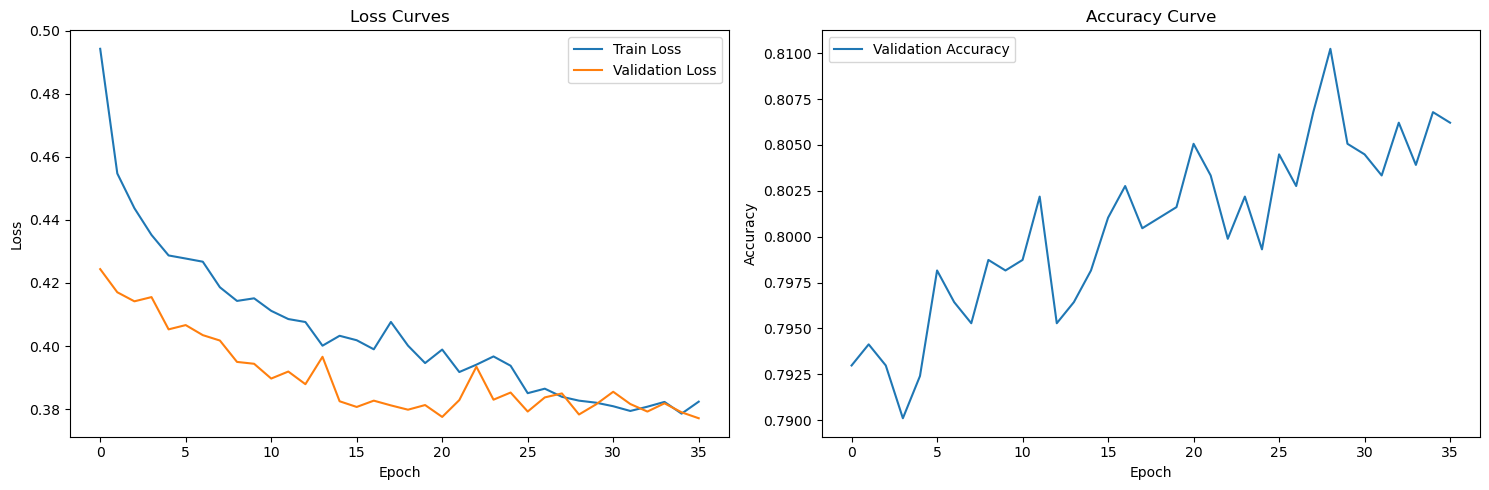


Best hyperparameters: {'batch_size': 64, 'dropout_rates': [0.3, 0.2, 0.2], 'layer_sizes': [256, 128, 64], 'learning_rate': 0.001, 'optimizer_name': 'adam'}
Submission file saved as 'submission_tuned.csv'
100%|███████████████████████████████████████| 56.3k/56.3k [00:00<00:00, 110kB/s]
400 Client Error: Bad Request for url: https://www.kaggle.com/api/v1/competitions/submissions/submit/spaceship-titanic
fileName        date                        description               status                     publicScore  privateScore  
--------------  --------------------------  ------------------------  -------------------------  -----------  ------------  
submission.csv  2025-04-04 19:38:42.343000  NN Approach               SubmissionStatus.COMPLETE  0.79237                    
submission.csv  2025-04-04 19:38:15         NN Approach               SubmissionStatus.COMPLETE  0.79682                    
submission.csv  2025-04-04 19:37:45.157000  NN Approach               SubmissionStatus.COMPLETE

In [33]:
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Create a directory to save models
os.makedirs('./models', exist_ok=True)

class SpaceshipNN(nn.Module):
    def __init__(self, input_size, layer_sizes=[128, 64, 32], dropout_rates=[0.3, 0.2, 0.2]):
        super(SpaceshipNN, self).__init__()
        
        # Dynamically create layers based on parameters
        layers = []
        prev_size = input_size
        
        for i, (size, dropout) in enumerate(zip(layer_sizes, dropout_rates)):
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_size = size
        
        # Output layer
        layers.append(nn.Linear(prev_size, 1))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, 
                       epochs=50, patience=5, scheduler=None, verbose=1):
    """
    Train model with early stopping and return best validation accuracy
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    best_val_acc = 0
    best_epoch = 0
    best_model_state = None
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_preds_binary = [1 if p > 0.5 else 0 for p in val_preds]
        val_acc = accuracy_score(val_labels, val_preds_binary)
        
        # Update learning rate if scheduler is provided
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        if verbose > 0 and (epoch + 1) % verbose == 0:
            print(f"Epoch {epoch+1}/{epochs}, "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")
        
        # Check if this is the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            if verbose > 0:
                print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    if verbose > 0:
        print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch+1}")
    
    return model, best_val_acc, history

def run_hyperparameter_tuning():
    """
    Run hyperparameter tuning and return the best model and parameters
    """
    # Define the hyperparameter grid
    param_grid = {
        'layer_sizes': [
            [64, 32],
            [128, 64],
            [128, 64, 32],
            [256, 128, 64]
        ],
        'dropout_rates': [
            [0.2, 0.2],
            [0.3, 0.2],
            [0.3, 0.2, 0.2],
            [0.4, 0.3, 0.2]
        ],
        'batch_size': [32, 64, 128],
        'learning_rate': [0.0001, 0.001, 0.01],
        'optimizer_name': ['adam', 'sgd']
    }
    
    # Ensure layer_sizes and dropout_rates have matching lengths
    param_combinations = list(ParameterGrid(param_grid))
    valid_combinations = []
    for params in param_combinations:
        if len(params['layer_sizes']) == len(params['dropout_rates']):
            valid_combinations.append(params)
        elif len(params['layer_sizes']) > len(params['dropout_rates']):
            # Extend dropout_rates with the last value
            params['dropout_rates'] = list(params['dropout_rates']) + [params['dropout_rates'][-1]] * (len(params['layer_sizes']) - len(params['dropout_rates']))
            valid_combinations.append(params)
        else:
            # Truncate dropout_rates
            params['dropout_rates'] = list(params['dropout_rates'])[:len(params['layer_sizes'])]
            valid_combinations.append(params)

    # Select 30 random combinations
    np.random.seed(42)
    np.random.shuffle(valid_combinations)
    valid_combinations = valid_combinations[:30]
    print(f"Running hyperparameter tuning on {len(valid_combinations)} combinations.")
    
    # Results tracking
    results = []
    best_acc = 0
    best_model = None
    best_params = None
    best_history = None
    
    # Run the grid search
    for i, params in enumerate(valid_combinations):
        print(f"\nTrial {i+1}/{len(valid_combinations)}")
        print(f"Parameters: {params}")
        
        # Create DataLoader with current batch size
        batch_size = params['batch_size']
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Create the model
        model = SpaceshipNN(
            input_size=X_train.shape[1],
            layer_sizes=params['layer_sizes'],
            dropout_rates=params['dropout_rates']
        )
        
        # Configure optimizer
        lr = params['learning_rate']
        if params['optimizer_name'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif params['optimizer_name'] == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        
        # Configure learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        
        # Train and evaluate
        try:
            model, val_acc, history = train_and_evaluate(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                optimizer=optimizer,
                criterion=nn.BCEWithLogitsLoss(),
                epochs=50,
                patience=7,
                scheduler=scheduler,
                verbose=5
            )
            
            # Save results
            results.append({
                'params': params,
                'val_acc': val_acc,
                'history': history
            })
            
            # Update best model if needed
            if val_acc > best_acc:
                best_acc = val_acc
                best_model = model
                best_params = params
                best_history = history
                
                # Save the best model
                timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'params': params,
                    'val_acc': val_acc
                }, f'./models/best_model_{timestamp}_{val_acc:.4f}.pt')
                
        except Exception as e:
            print(f"Error with parameters {params}: {e}")
    
    # Sort results by validation accuracy
    results.sort(key=lambda x: x['val_acc'], reverse=True)
    
    # Print top 5 results
    print("\nTop 5 models:")
    for i, res in enumerate(results[:5]):
        print(f"{i+1}. Validation Accuracy: {res['val_acc']:.4f}, Parameters: {res['params']}")
    
    # Plot learning curves for the best model
    if best_history:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(best_history['train_loss'], label='Train Loss')
        plt.plot(best_history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss Curves')
        
        plt.subplot(1, 2, 2)
        plt.plot(best_history['val_acc'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy Curve')
        
        plt.tight_layout()
        plt.show()
    
    return best_model, best_params, results

# Run hyperparameter tuning
best_model, best_params, tuning_results = run_hyperparameter_tuning()

print(f"\nBest hyperparameters: {best_params}")

# Make predictions with the best model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)
best_model.eval()

test_preds = []
with torch.no_grad():
    for features in test_loader:
        features = features.to(device)
        outputs = best_model(features).squeeze()
        test_preds.extend(torch.sigmoid(outputs).cpu().numpy())

# Convert predictions to binary
test_preds_binary = [1 if p > 0.5 else 0 for p in test_preds]

# Create a submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': [bool(p) for p in test_preds_binary]
})

# Save the submission file
submission.to_csv('submission_tuned.csv', index=False)
print("Submission file saved as 'submission_tuned.csv'")

# Submit to Kaggle
competition_name = "spaceship-titanic"
submission_path = './submission_tuned.csv'
!kaggle competitions submit -c {competition_name} -f {submission_path} -m "NN with Hyperparameter Tuning"
!kaggle competitions submissions -c {competition_name}

In [34]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    val_preds_binary = [1 if p > 0.5 else 0 for p in val_preds]
    val_accuracy = accuracy_score(val_labels, val_preds_binary)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

# Make predictions on the test set
model.eval()
test_preds = []
with torch.no_grad():
    for features in test_loader:
        outputs = model(features).squeeze()
        test_preds.extend(torch.sigmoid(outputs).cpu().numpy())

# Convert predictions to binary
test_preds_binary = [1 if p > 0.5 else 0 for p in test_preds]

# Create a submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': [bool(p) for p in test_preds_binary]
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Epoch 1/10, Train Loss: 0.5474, Val Loss: 0.4570, Val Accuracy: 0.7786
Epoch 2/10, Train Loss: 0.4655, Val Loss: 0.4275, Val Accuracy: 0.7895
Epoch 3/10, Train Loss: 0.4556, Val Loss: 0.4207, Val Accuracy: 0.7936
Epoch 4/10, Train Loss: 0.4442, Val Loss: 0.4164, Val Accuracy: 0.7930
Epoch 5/10, Train Loss: 0.4387, Val Loss: 0.4131, Val Accuracy: 0.7959
Epoch 6/10, Train Loss: 0.4327, Val Loss: 0.4109, Val Accuracy: 0.7918
Epoch 7/10, Train Loss: 0.4351, Val Loss: 0.4090, Val Accuracy: 0.7861
Epoch 8/10, Train Loss: 0.4334, Val Loss: 0.4060, Val Accuracy: 0.7947
Epoch 9/10, Train Loss: 0.4283, Val Loss: 0.4048, Val Accuracy: 0.7936
Epoch 10/10, Train Loss: 0.4259, Val Loss: 0.4083, Val Accuracy: 0.7907
Submission file saved as 'submission.csv'


In [35]:
competition_name = "spaceship-titanic"
submission_path = './submission.csv'
!kaggle competitions submit -c {competition_name} -f {submission_path} -m "NN Approach"

100%|███████████████████████████████████████| 56.5k/56.5k [00:00<00:00, 159kB/s]
400 Client Error: Bad Request for url: https://www.kaggle.com/api/v1/competitions/submissions/submit/spaceship-titanic


In [36]:
!kaggle competitions submissions -c {competition_name}

fileName        date                        description               status                     publicScore  privateScore  
--------------  --------------------------  ------------------------  -------------------------  -----------  ------------  
submission.csv  2025-04-04 19:38:42.343000  NN Approach               SubmissionStatus.COMPLETE  0.79237                    
submission.csv  2025-04-04 19:38:15         NN Approach               SubmissionStatus.COMPLETE  0.79682                    
submission.csv  2025-04-04 19:37:45.157000  NN Approach               SubmissionStatus.COMPLETE  0.79822                    
submission.csv  2025-04-04 19:23:37.603000  NN Approach               SubmissionStatus.COMPLETE  0.80476                    
submission.csv  2025-04-04 19:23:27.843000  NN Approach               SubmissionStatus.COMPLETE  0.79915                    
submission.csv  2025-04-04 19:17:23.473000  Model Selection Approach  SubmissionStatus.COMPLETE  0.79915                    
